In [ ]:
import os
import shutil

# 1) Define repo URL and local directory name
REPO_URL = "https://github.com/semilleroCV/breastcatt.git"
REPO_DIR = "breastcatt"

# 2) Delete the directory if it exists
if os.path.isdir(REPO_DIR):
    print(f"Directory '{REPO_DIR}' exists. Deleting it...")
    shutil.rmtree(REPO_DIR)

# 3) Clone the repository
print(f"Cloning repository into ./{REPO_DIR}...")
os.system(f"git clone {REPO_URL}")

# 4) Change into the repo directory
os.chdir(REPO_DIR)
print("Current working directory:", os.getcwd())

In [ ]:
# every time you do a factory reset you have to run this
!pip install --upgrade -r requirements.txt -q

In [2]:
# IF YOU ARE WORKING ON KAGGLE OR GOOGLE COLAB DO NOT EXECUTE THIS CELL

import sys
import os

sys.path.append(os.path.abspath("../"))

In [3]:
import torch
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from torchvision import transforms
from breastcatt import tfvit
from huggingface_hub import hf_hub_download
import json

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## inference on DMR-IR

In [ ]:
# --- ONLY RUN THIS CELL to Load one of our models ---
MODEL_REPO_ID = "SemilleroCV/tfvit-base-text-2" # it can be base, base-text and base-text-seg

print(f"Loading model from {MODEL_REPO_ID}...")
config_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="config.json")
try:
    state_dict_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="pytorch_model.bin")
except:
    state_dict_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="model.safetensors")

# Load config
with open(config_path, "r") as f:
    init_args = json.load(f)

# Init model
model = (tfvit.multimodal_vit_large_patch16(**init_args) if init_args["embed_dim"] == 1024
         else tfvit.multimodal_vit_base_patch16(**init_args))

# Load and adapt state dict
state_dict = load_file(state_dict_path, device="cpu") if state_dict_path.endswith("safetensors") \
            else torch.load(state_dict_path, map_location="cpu")

# Key renaming
state_dict = {k.replace("text_embed_proj.", "language_model.proj."): v 
              for k, v in state_dict.items()}

# Load weights (ignore missing LM weights)
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)

Loading model from SemilleroCV/tfvit-base-text-2...
✅ MAE base weights already exist at: checkpoints/fvit/mae_pretrain_vit_base.pth
Loading checkpoint from: checkpoints/fvit/mae_pretrain_vit_base.pth
Adapting patch_embed.proj.weight from 3 channels to 1 channel...

✅ Loaded weights: 148 layers.
❌ Not found in model: 0 layers.
📋 Details of load_state_dict:
_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'language_model.model_lm.embeddings.word_embeddings.weight', 'language_model.model_lm.embeddings.position_embeddings.weight', 'language_model.model_lm.embeddings.token_type_embeddings.weight', 'language_model.model_lm.encoder.layer.0.attention.ln.weight', 'language_model.model_lm.encoder.layer.0.attention.ln.bias', 'language_model.model_lm.encoder.layer.0.attention.self.query.weight', 'language_model.model_lm.encoder.layer.0.attention.self.query.bias', 'language_model.model_lm.encoder.layer.0.attention.self.key.weight', 'language_model.model_lm.encoder.layer.0.attention.self.ke

MultiModalVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (language_model): LanguageModel(
    (model_lm): MegatronBertModel(
      (embeddings): MegatronBertEmbeddings(
        (word_embeddings): Embedding(50176, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): MegatronBertEncoder(
        (layer): ModuleList(
          (0-23): 24 x MegatronBertLayer(
            (attention): MegatronBertAttention(
              (ln): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (self): MegatronBertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): L

Prompt: '['Patient is 84 years old of white race. Has eating habits low in fat. Family history reported diabetes. Additionally, patient reported no. In the clinical history, radiotherapy was no, use of hormone replacement was no. Regarding the protocol, a body temperature of 35.00 degrees Celsius, alcohol consumption was no, coffee drinking was no, smoking was yes, physical exercise was no.']'


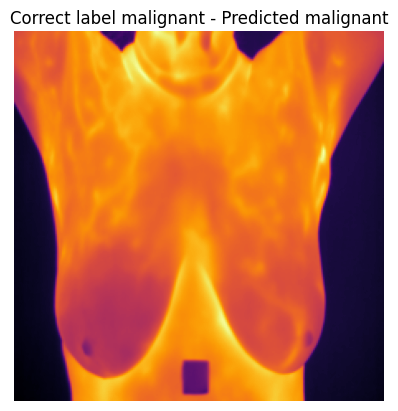

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SemilleroCV/DMR-IR", revision="69ffd6240b4a50bc4a05c59b70773f3a506054f2")

# Get the label names
labels = dataset["train"].features["label"].names
id2label = {str(i): label for i, label in enumerate(labels)}

train_val_split = 0.15

# If we don't have a validation split, split off a percentage of train as validation.
train_val_split = None if "validation" in dataset.keys() else train_val_split
if isinstance(train_val_split, float) and train_val_split > 0.0:
    split = dataset["train"].train_test_split(train_val_split, seed=0)
    dataset["train"] = split["train"]
    dataset["validation"] = split["test"]

validation_set = dataset["validation"]

# Min-max normalization to [0, 1] for floating-point TIFFs
min_max_norm = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8))

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        min_max_norm,
    ]
)

def preprocess_val(example_batch):
    """Apply _val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image) for image in example_batch["image"]
    ]
    return example_batch

# Select sample
sample = validation_set[10] # 👈 Change this number to select another patient

# Apply preprocessing
sample["pixel_values"] = val_transforms(sample["image"])

# Move to batch format
pixel_values = sample["pixel_values"].unsqueeze(0).to(DEVICE)  # [1, C, H, W]
texts = [sample["text"]]
print(f"Prompt: '{texts}'")

# Get the label for comparison
label = id2label[str(sample["label"])]

# Forward pass
model.eval()
with torch.no_grad():
    output = model(pixel_values=pixel_values, texts=texts)

# Get prediction
pred = id2label['1'] if torch.sigmoid(output.logits).item() > 0.5 else id2label['0']

# Plot the results
plt.imshow(pixel_values.squeeze(0).squeeze(0).cpu().numpy(), cmap='inferno')
plt.title(f"Correct label {label} - Predicted {pred}")
plt.axis('off')  # Remove axes for a clean image
plt.show()

## inference on BreastThermography

In [ ]:
# --- ONLY RUN THIS CELL to Load one of our models ---
MODEL_REPO_ID = "SemilleroCV/tfvit-base-text-2" # it can be base, base-text and base-text-seg

print(f"Loading model from {MODEL_REPO_ID}...")
config_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="config.json")
try:
    state_dict_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="pytorch_model.bin")
except:
    state_dict_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="model.safetensors")

# Load config
with open(config_path, "r") as f:
    init_args = json.load(f)

# Init model
model = (tfvit.multimodal_vit_large_patch16(**init_args) if init_args["embed_dim"] == 1024
         else tfvit.multimodal_vit_base_patch16(**init_args))

# Load and adapt state dict
state_dict = load_file(state_dict_path, device="cpu") if state_dict_path.endswith("safetensors") \
            else torch.load(state_dict_path, map_location="cpu")

# Key renaming
state_dict = {k.replace("text_embed_proj.", "language_model.proj."): v 
              for k, v in state_dict.items()}

# Load weights (ignore missing LM weights)
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)

Loading model from SemilleroCV/tfvit-base-text-2...
✅ MAE base weights already exist at: checkpoints/fvit/mae_pretrain_vit_base.pth
Loading checkpoint from: checkpoints/fvit/mae_pretrain_vit_base.pth
Adapting patch_embed.proj.weight from 3 channels to 1 channel...

✅ Loaded weights: 148 layers.
❌ Not found in model: 0 layers.
📋 Details of load_state_dict:
_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'language_model.model_lm.embeddings.word_embeddings.weight', 'language_model.model_lm.embeddings.position_embeddings.weight', 'language_model.model_lm.embeddings.token_type_embeddings.weight', 'language_model.model_lm.encoder.layer.0.attention.ln.weight', 'language_model.model_lm.encoder.layer.0.attention.ln.bias', 'language_model.model_lm.encoder.layer.0.attention.self.query.weight', 'language_model.model_lm.encoder.layer.0.attention.self.query.bias', 'language_model.model_lm.encoder.layer.0.attention.self.key.weight', 'language_model.model_lm.encoder.layer.0.attention.self.ke

MultiModalVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (language_model): LanguageModel(
    (model_lm): MegatronBertModel(
      (embeddings): MegatronBertEmbeddings(
        (word_embeddings): Embedding(50176, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): MegatronBertEncoder(
        (layer): ModuleList(
          (0-23): 24 x MegatronBertLayer(
            (attention): MegatronBertAttention(
              (ln): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (self): MegatronBertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): L

Prompt: '['Patient is 55 years old, weighs 94.0 kilograms, and is 158.7 centimeters tall. Regarding the protocol, a body temperature of 36.2 degrees Celsius.']'


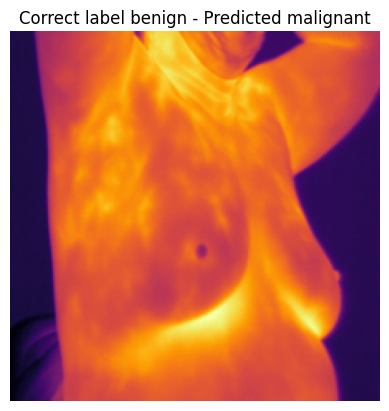

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SemilleroCV/BreastThermography", revision="6a84021f2a5b253d0da72f7948de93613fd9a788")

# Get the label names
labels = dataset["train"].features["label"].names
id2label = {str(i): label for i, label in enumerate(labels)}

train_val_split = 0.15

# If we don't have a validation split, split off a percentage of train as validation.
train_val_split = None if "validation" in dataset.keys() else train_val_split
if isinstance(train_val_split, float) and train_val_split > 0.0:
    split = dataset["train"].train_test_split(train_val_split, seed=0)
    dataset["train"] = split["train"]
    dataset["validation"] = split["test"]

validation_set = dataset["validation"]

# Min-max normalization to [0, 1] for floating-point TIFFs
min_max_norm = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8))

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        min_max_norm,
    ]
)

def preprocess_val(example_batch):
    """Apply _val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image) for image in example_batch["image"]
    ]
    return example_batch

# Select sample
sample = validation_set[10] # 👈 Change this number to select another patient

# Apply preprocessing
sample["pixel_values"] = val_transforms(sample["image"])

# Move to batch format
pixel_values = sample["pixel_values"].unsqueeze(0).to(DEVICE)  # [1, C, H, W]
texts = [sample["text"]]
print(f"Prompt: '{texts}'")

# Get the label for comparison
label = id2label[str(sample["label"])]

# Forward pass
model.eval()
with torch.no_grad():
    output = model(pixel_values=pixel_values, texts=texts)

# Get prediction
pred = id2label['1'] if torch.sigmoid(output.logits).item() > 0.5 else id2label['0']

# Plot the results
plt.imshow(pixel_values.squeeze(0).squeeze(0).cpu().numpy(), cmap='inferno')
plt.title(f"Correct label {label} - Predicted {pred}")
plt.axis('off')  # Remove axes for a clean image
plt.show()